In [1]:
from sympy import *

init_printing()

In [2]:
toty, density = symbols(r"\mathrm{tot_y}, \mathrm{density}")
gammar, betar = symbols(r"\gamma_r \beta_r")
toty, density, gammar, betar

In [3]:
deltapcm_x = Symbol(r"\Delta p_cmx")
deltapcm_y = Symbol(r"\Delta p_cmy")
deltapcm_z = Symbol(r"\Delta p_cmz")
# deltapcm_x, deltapcm_y, deltapcm_z

In [4]:
deltapcm_t = Symbol(r"\Delta p_{cm}^{transverse}")
deltapcm_n = Symbol(r"\Delta p_{cm}^{n}")
# deltapcm_t, deltapcm_n

In [5]:
phi, psi = symbols(r"\phi \psi")
# phi, psi

In [6]:
betatilda, C = symbols(r"\tilde{\beta} C")
coulog = log(C)
# betatilda, coulog

In [7]:
one_minus_cospsi = 1 - cos(psi)
sin_psi = sin(psi)
cos_phi, sin_phi = cos(phi), sin(phi)

## Computing the deltas - Case 1

This is if $C > 1$

In [8]:
deltap1cmx = (
    -deltapcm_x * one_minus_cospsi
    + (sin_psi * cos_phi * deltapcm_x * deltapcm_z - sin_psi * sin_phi * deltapcm_n * deltapcm_y) / deltapcm_t
) / 2.0

deltap1cmy = (
    -deltapcm_y * one_minus_cospsi
    + (sin_psi * cos_phi * deltapcm_y * deltapcm_z - sin_psi * sin_phi * deltapcm_n * deltapcm_x) / deltapcm_t
) / 2.0

deltap1cmz = (-deltapcm_z * one_minus_cospsi - sin_psi * cos_phi * deltapcm_t) / 2.0 * gammar

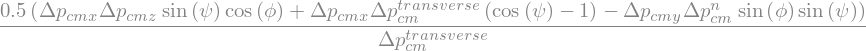

In [9]:
simplify(deltap1cmx)

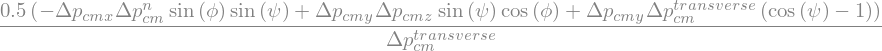

In [10]:
simplify(deltap1cmy)

In [11]:
simplify(deltap1cmz)

## Computing the deltas - Case 2

This is the other case

In [12]:
deltap1cmx_c2 = deltapcm_n * sin_psi * cos_phi / 2.0
deltap1cmy_c2 = deltapcm_n * sin_psi * sin_phi / 2.0
deltap1cmz_c2 = -deltapcm_n * one_minus_cospsi / 2.0 * gammar

In [13]:
simplify(deltap1cmx_c2)

In [14]:
simplify(deltap1cmy_c2)

In [15]:
simplify(deltap1cmz_c2)

## Now as a function?

In [16]:
import numpy as np
import xtrack as xt
from scipy.constants import c

In [17]:
def collide_parts(idx1: int, idx2: int, toty: float, density: float, delta_t: float, particles: xt.Particles):
    nplike = particles._context.nplike_lib
    rng = nplike.random.default_rng()
    (beta0,) = particles.beta0[idx1]  # same for both
    gamma0 = particles.gamma0[idx1]  # same for both
    r0 = particles.get_classical_particle_radius0()
    # ----------------------------------------------
    # We compute the delta_u from Takizuka and Abe (momentum diffs)
    deltapcmx = particles.px[idx1] - particles.px[idx2]
    deltapcmy = particles.py[idx1] - particles.py[idx2]
    deltapcmz = (particles.delta[idx1] - particles.delta[idx2]) / gammar  # gammar in SIRE
    # ----------------------------------------------
    # We compute the transverse u_T and the n (complete?) one (from SIRE)
    deltapcmt = nplike.sqrt(deltapcmx**2 + deltapcmy**2)
    deltapcmn = nplike.sqrt(deltapcmt**2 + deltapcmz**2)
    # ----------------------------------------------
    phi = 2 * np.pi * rng.random()  # polar collision angle, random uniform between 0 and 2pi
    betatilde = beta0 * gamma0 * deltapcmn / 2
    coulomb = toty * betatilda**2 / r0
    # ----------------------------------------------
    # Firstly, assert we can get a Coulog otherwise ignore all
    if coulomb <= 1:
        return
    # ----------------------------------------------
    # Firstly, assert we can get a Coulog otherwise ignore all
    coulog = nplike.log(coulomb)
    ome_minus_cos_psi = 2 * np.pi * c * density * r0**2 * delta_t * coulog / (gamma0**2 * betatilda**3)
    sin_psi = np.sqrt(2) * nplike.sqrt(one_minus_cospsi)
    # ----------------------------------------------
    # Two cases on determining the deltap in each dimension
    if deltapcm_t != 0:  # There is non-zero deltapcmt (transverse u_T)
        deltap1cmx = (
            -deltapcmx * ome_minus_cos_psi
            + (sin_psi * np.cos(phi) * deltapcmx * deltapcmz - sin_psi * np.sin(phi) * deltapcmn * deltapcmy) / deltapcmt
        ) / 2.0
        deltap1cmy = (
            -deltapcmy * ome_minus_cos_psi
            + (sin_psi * np.cos(phi) * deltapcmy * deltapcmz - sinpsi * np.sin(phi) * deltapcmn * deltapcmx) / deltapcmt
        ) / 2.0
        deltap1cmz = gamma0 * (-deltapcmz * ome_minus_cos_psi - sin_psi * np.cos(phi) * deltapcmt) / 2.0
    else:  # There is zero deltapcmt (transverse u_T)
        deltap1cmx = deltapcmn * sin_psi * np.cos(phi) / 2.0
        deltap1cmy = deltapcmn * sin_psi * np.sin(phi) / 2.0
        deltap1cmz = gamma0 * (-deltapcmn * ome_minus_cos_psi) / 2.0
    # ----------------------------------------------
    # Apply the deltas to the particles (add to part1, remove from part2)
    particles.px[idx1] += deltap1cmx
    particles.py[idx1] += deltap1cmy
    particles.delta[idx1] += deltap1cmz
    particles.px[idx2] -= deltap1cmx
    particles.py[idx2] -= deltap1cmy
    particles.delta[idx2] -= deltap1cmz

---